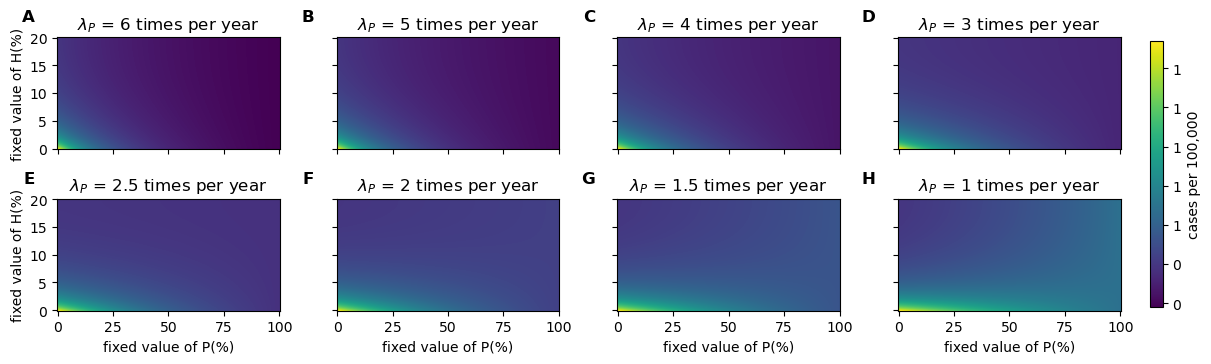

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define parameters
args = {
    "beta_HIV": 0.6341 / 360.0,
    "beta_STI": 0.0016 * 5.0,
    "mu": 1.0 / 45.0 / 360.0,
    "gamma_STI": 1.0 / 1.32 / 360.0,
    "gammaT_STI": 1.0 / 14.0,
    "lambda_P": 1 / 3 / 360,
    "asymptomatic": 0.9,
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.0,
    "H_tau": 0.2,
    "c": 50.0,
    "minexp":0,
    "H":0,
    "P_HIV": 0.0,
    "maxexp":1,
    
}

# Mitigation function
def m(H, min_exp=args["minexp"], max_exp=args["maxexp"], tau_exp=args["H_tau"]):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))

# Define the equation for alpha
def alpha(P, H, beta_STI=args["beta_STI"]):
    return beta_STI * (1 - m(H) * (1 - P))

# Define the equation for I^{a,*}_{STI}
def I_star_STI(H, P, lam_P, beta_HIV=args["beta_HIV"], mu=args["mu"], gamma=args["gamma_STI"], C=args["c"], psi=args["asymptomatic"], tgamma=args["gammaT_STI"]):
    P_star = P
    H_star = H
    m_star = m(H_star)
    alpha_val = alpha(P_star, H_star)
    
    term1 = (mu + tgamma) * (mu / ((psi * alpha_val * mu / (gamma + lam_P * P_star + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star) + mu) + (1 - psi) * alpha_val) - 1))
    term2 = -(gamma + lam_P * P_star + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star) + mu) / psi
    term3 = gamma - tgamma * ((1 + (gamma + lam_P * P_star + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star) + mu) / mu) * (1 - psi) / psi)
    
    numerator = term1
    denominator = term2 + term3
    
    return numerator / denominator

# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2.5 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Calculate I_star_STI values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            I_values[i, j] = I_star_STI(H, P, lambda_P)
    results[lambda_P] = I_values

# Determine the global vmin and vmax
all_infections = np.concatenate([results[lambda_P].flatten() for lambda_P in lambda_P_values])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Plotting
num_lambda_P = len(lambda_P_values)
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(2, num_lambda_P // 2, figsize=(3 * num_lambda_P // 2, 3.5), constrained_layout=True, gridspec_kw=gridspec)

nrows, ncols = axes.shape
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[50] * 100), int(Ps[100] * 100), int(Ps[150] * 100), int(Ps[200] * 100)])
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([int(Hs[0] * 100), int(Hs[25] * 100), int(Hs[50] * 100), int(Hs[75] * 100), int(Hs[100] * 100)])
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(-0.1, 1.25, chr(65 + idx), transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="right")

# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"

# Create a single color bar for the whole figure
cbar = fig.colorbar(cax, ax=axes.ravel().tolist(), shrink=0.88, format=FuncFormatter(formatter), pad=0.015)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()

